In [1]:
# !pip install gqlalchemy
# !pip install datasets
# !pip install -U sentence-transformers
# !pip install networkx 

In [2]:
# Setup and check memgraph connection
import json
from gqlalchemy import Memgraph

def load_credentials(filepath):
    try:
        with open(filepath, 'r') as f:
            credentials = json.load(f)
        return credentials
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {filepath}")
        return None

filepath = 'credentials.json'
credentials = load_credentials(filepath)

MEMGRAPH_HOST = credentials['MEMGRAPH_HOST']
MEMGRAPH_PORT = credentials['MEMGRAPH_PORT']
MEMGRAPH_USERNAME = credentials['MEMGRAPH_USERNAME']
MEMGRAPH_PASSWORD = credentials['MEMGRAPH_PASSWORD']


def hello_memgraph(host: str, port: int, username: str, password: str):
    memgraph = Memgraph(host, port, username, password, encrypted=True)
    results = memgraph.execute_and_fetch(
        'CREATE (n:FirstNode { message: "Hello Memgraph from Python!" }) RETURN n.message AS message'
    )
    print("Created node with message:", next(results)["message"])

if __name__ == "__main__":
    hello_memgraph(MEMGRAPH_HOST, MEMGRAPH_PORT, MEMGRAPH_USERNAME, MEMGRAPH_PASSWORD)

memgraph = Memgraph(MEMGRAPH_HOST, MEMGRAPH_PORT, MEMGRAPH_USERNAME, MEMGRAPH_PASSWORD, encrypted=True)

Created node with message: Hello Memgraph from Python!


In [3]:
# Load dataset from HuggingFace
import pandas as pd
from datasets import load_dataset

data = load_dataset('jacob-hugging-face/job-descriptions')

df = pd.DataFrame(columns=['title','description','company'])
df['title'] = data['train']['position_title']
df['description'] = data['train']['job_description']
df['company'] = data['train']['company_name']
df.head(10)

,title,description,company
0,Sales Specialist,minimum qualifications\nbachelors degree or eq...,Google
1,Apple Solutions Consultant,description\nas an asc you will be highly infl...,Apple
2,Licensing Coordinator - Consumer Products,its an amazing time to be joining netflix as w...,Netflix
3,Web Designer,description\n\nweb designers looking to expand...,Robert Half
4,Web Developer,at trackfive weve got big goals were on a miss...,TrackFive
5,Frontend Web Developer,designups is a nashville based design and inte...,DesignUps
6,Remote Website Designer,about the position\n\nthe web designer is resp...,"Equisolve, Inc."
7,Web Designer,job description\n\nzander insurance group is o...,Zander Insurance Agency
8,Web Designer,tuff is a growth marketing team working with c...,Tuff
9,SR. Web Designer,type of requisition regular\n\nclearance level...,General Dynamics Information Technology


In [4]:
# Generate embedding for each job description
from sentence_transformers import SentenceTransformer

def compute_embeddings(text):
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    return model.encode(text)

embeddings = compute_embeddings(df['description'].values)

print(f"{len(embeddings[0])}-d Embeddings created for job descriptions")

384-d Embeddings created for job descriptions


In [5]:
# Clear graph and insert data using gqalchemy
memgraph.execute("MATCH (n) DETACH DELETE n")

rows=0
for index, row in df.iterrows():
    title = row["title"].replace('"', '')
    embedding = embeddings[index].tolist()
    memgraph.execute(
        """
        CREATE (:Job {title: $title, embedding: $embedding});
        """,
        {"title": title, "embedding": embedding}
    )
    rows+=1
    
print(f"{rows} Job nodes with embeddings created in Memgraph.")

853 Job nodes with embeddings created in Memgraph.


In [6]:
# Create vector index
memgraph.execute("DROP VECTOR INDEX job_descs;")
memgraph.execute("""
        CREATE VECTOR INDEX job_descs ON :Job(embedding) WITH CONFIG {"dimension": 384, "capacity": 1000, "metric": "cos"};
                     """)

# Verify vector index created
check = memgraph.execute_and_fetch("""
    CALL vector_search.show_index_info() YIELD * RETURN *;                
                                      """)
for row in check:
    print("Created vector index:", row)

Created vector index: {'capacity': 2048, 'dimension': 384, 'index_name': 'job_descs', 'label': 'Job', 'metric': 'cos', 'property': 'embedding', 'size': 853}


In [7]:
import networkx as nx
import matplotlib.pyplot as plt

def show_relevant_jobs(query, k=10):
    query_vector = compute_embeddings(query).tolist()
    results = memgraph.execute_and_fetch(
        f"""
        CALL vector_search.search("job_descs", {k}, $embedding) YIELD node, similarity RETURN node.title AS title, node.description AS description, similarity; 
        """,
        {"embedding": query_vector}
    )

    G = nx.Graph()
    query_node = query
    G.add_node(query_node)

    # Add nodes and edges with similarity-based weights
    for row in results:
        title = row["title"]
        similarity = row["similarity"]
        print(title, round(similarity,3))
        
        G.add_node(title, similarity=similarity)
        G.add_edge(query_node, title, weight=similarity)

    # Position nodes using edge weights
    pos = nx.spring_layout(G, weight='weight', seed=42)

    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    nx.draw(
        G, pos,
        with_labels=True,
        node_color='skyblue',
        node_size=2000,
        edge_color='gray',
        font_size=10,
        font_weight='bold'
    )
    plt.title(f"Top {k} Relevant Jobs to '{query}'")
    plt.axis('off')
    plt.margins(0.25)
    plt.show()

Assistant Controller- Construction Industry 0.453
Senior Accountant (Remote) (Remote) 0.436
Business Banking Relationship Manager 0.428
Customer Service - Fraud Liaison Specialist 0.426
Data Entry Specialist 0.424
Senior Business Associate, VP 0.421
Senior Full Stack Software Engineer- Remote 0.416
Senior Data Security Engineer, Vice President - Remote 0.416
Credit Collections Lead 0.408
Executive Assistant to the CEO 0.408


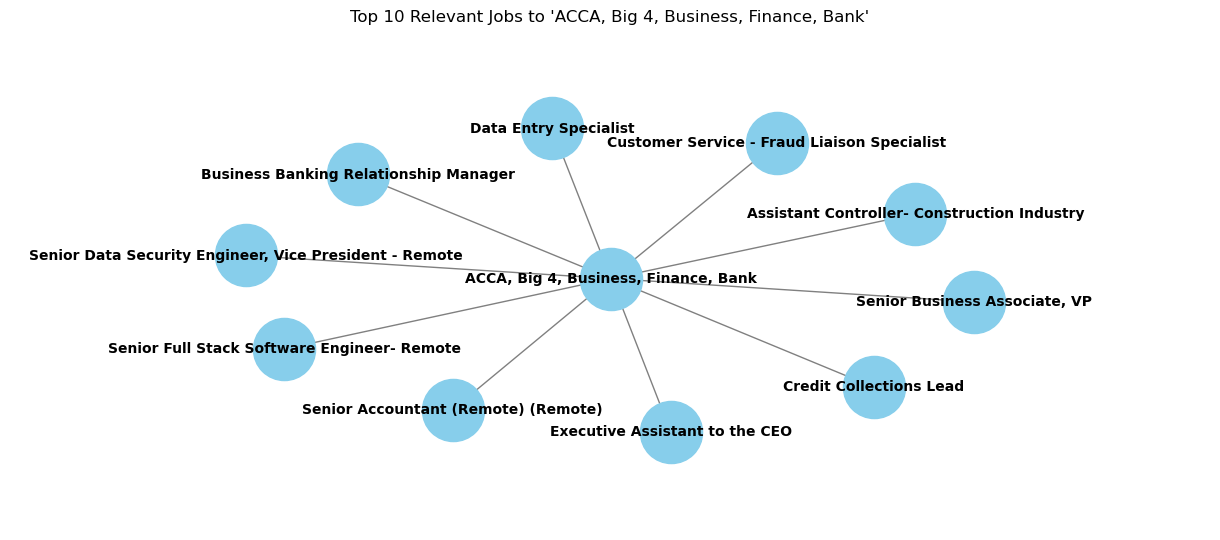

In [8]:
show_relevant_jobs("ACCA, Big 4, Business, Finance, Bank")

Mainframe Programmer Analyst 0.449
Analytics Manager 0.439
Data Analyst/Manager 0.424
Data Analyst Manager 0.392
SR. Web Designer 0.383
REMOTE Data Entry/Auditor 0.379
Oracle E-Business Programmer & Decision Support 0.378
Regional Sales Director, SAP - NE - United States 0.375
Data Analytics Senior Mangager 0.366
Data Entry - Work from Home - International Applicants Accepted 0.364


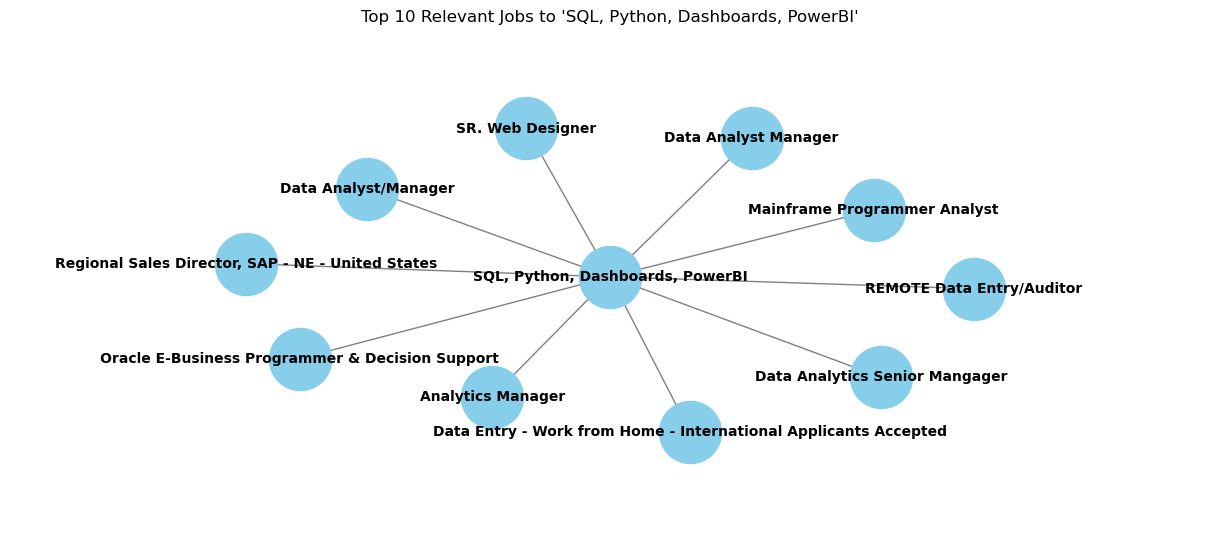

In [9]:
show_relevant_jobs("SQL, Python, Dashboards, PowerBI")